In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
save_dir1 = "../figures/magnetic_data_EDA/transformed_plots"
os.makedirs(save_dir1, exist_ok=True)

# 2020 Data Analysis

In [3]:
ddf = dd.read_parquet("../data/processed/magnetic_data/train/", engine = "pyarrow")
print("--- Loaded the PROCESSED dataset ---")

--- Loaded the PROCESSED dataset ---


In [4]:
print("Verifying DataFrame structure and column types:")
print(ddf.info())
print("\n------------------------------------------\n")
print("Verifying descriptive statistics of the final features:")
print(ddf.describe().compute())

Verifying DataFrame structure and column types:
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 14 entries, record_id to MEANSHR_lag3
dtypes: float64(11), int64(2), string(1)None

------------------------------------------

Verifying descriptive statistics of the final features:
          record_id        seq_id    USFLUX_log    TOTPOT_log   PIL_LEN_log  \
count  1.252710e+07  1.252710e+07  1.252710e+07  1.252710e+07  1.252710e+07   
mean   9.132432e+04  4.147299e+01  4.877684e+01  5.049018e+01  2.293483e+00   
std    4.608442e+04  2.957944e+01  4.357264e+00  4.723063e+00  2.536078e+00   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.423400e+04  1.800000e+01  4.777628e+01  4.906277e+01  0.000000e+00   
50%    1.007600e+05  3.700000e+01  4.914165e+01  5.058519e+01  1.609438e+00   
75%    1.284250e+05  5.600000e+01  5.049064e+01  5.279293e+01  4.430817e+00   
max    1.710370e+05  1.190000e+02  5.322033e+01  6.202874e+01  1.016950e+01   

  

# Distribution Visualization

In [5]:
numeric_ddf = ddf.select_dtypes(include = ['float64'])

In [6]:
sample_df = numeric_ddf.sample(frac=0.01).compute()

In [7]:
quantiles = numeric_ddf.quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]).compute()



------------- Verifying Distribution for USFLUX_log -------------

Quantiles for USFLUX_log:
0.00     0.000000
0.25    47.763032
0.50    49.130009
0.75    50.481767
0.90    51.354509
0.95    51.786403
0.99    52.411569
1.00    53.220333
Name: USFLUX_log, dtype: float64


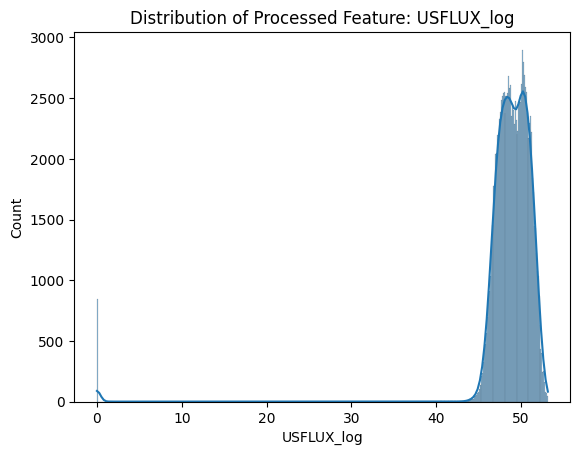



------------- Verifying Distribution for TOTPOT_log -------------

Quantiles for TOTPOT_log:
0.00     0.000000
0.25    49.045931
0.50    50.563412
0.75    52.775748
0.90    54.060498
0.95    54.544249
0.99    55.423245
1.00    62.028737
Name: TOTPOT_log, dtype: float64


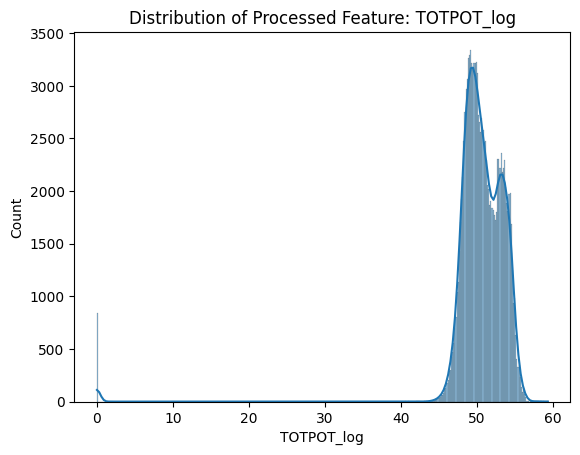



------------- Verifying Distribution for PIL_LEN_log -------------

Quantiles for PIL_LEN_log:
0.00     0.000000
0.25     0.000000
0.50     1.609438
0.75     4.418841
0.90     6.190315
0.95     7.012115
0.99     8.285513
1.00    10.169499
Name: PIL_LEN_log, dtype: float64


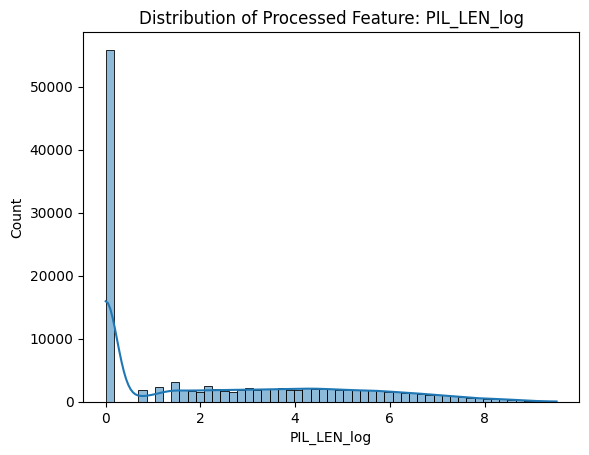



------------- Verifying Distribution for MEANSHR -------------

Quantiles for MEANSHR:
0.00      0.000000
0.25     21.572367
0.50     23.616591
0.75     31.091490
0.90     39.943609
0.95     44.080777
0.99     50.033331
1.00    135.784277
Name: MEANSHR, dtype: float64


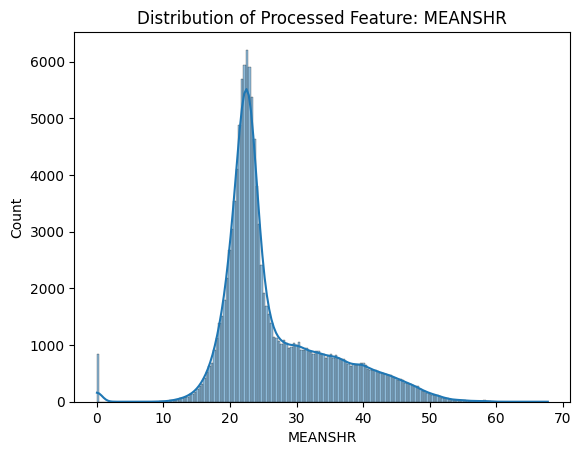



------------- Verifying Distribution for TOTFZ -------------

Quantiles for TOTFZ:
0.00   -5.264704e+25
0.25   -3.054331e+24
0.50   -8.475424e+23
0.75   -2.163247e+23
0.90   -8.081158e+22
0.95   -4.753054e+22
0.99   -9.475940e+21
1.00    3.770667e+24
Name: TOTFZ, dtype: float64


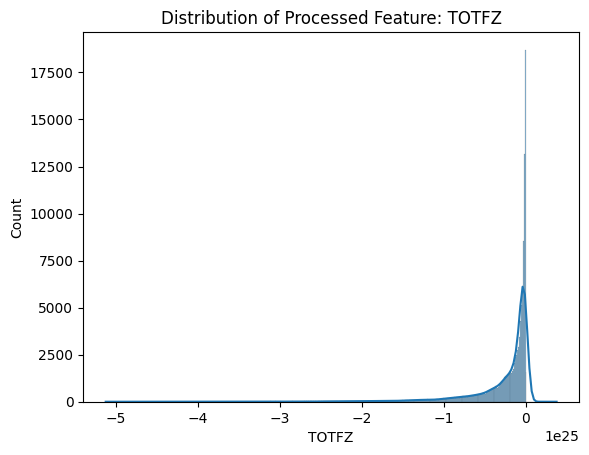



------------- Verifying Distribution for EPSZ -------------

Quantiles for EPSZ:
0.00   -0.990590
0.25   -0.632908
0.50   -0.574002
0.75   -0.392908
0.90   -0.212009
0.95   -0.141800
0.99   -0.031146
1.00    0.999210
Name: EPSZ, dtype: float64


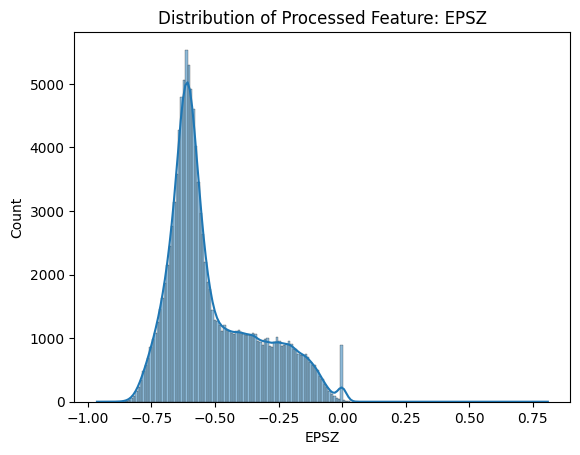



------------- Verifying Distribution for R_VALUE -------------

Quantiles for R_VALUE:
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    3.609780
0.90    4.346927
0.95    4.658704
0.99    5.100260
1.00    5.838592
Name: R_VALUE, dtype: float64


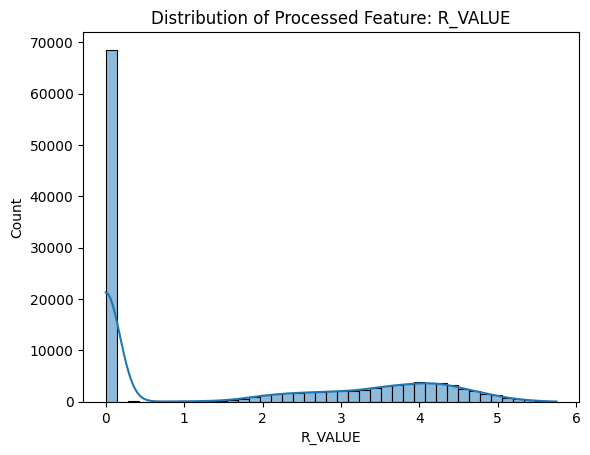



------------- Verifying Distribution for USFLUX_log_roll_mean5 -------------

Quantiles for USFLUX_log_roll_mean5:
0.00     0.000000
0.25    47.752096
0.50    49.112113
0.75    50.453296
0.90    51.327649
0.95    51.757471
0.99    52.395492
1.00    53.175358
Name: USFLUX_log_roll_mean5, dtype: float64


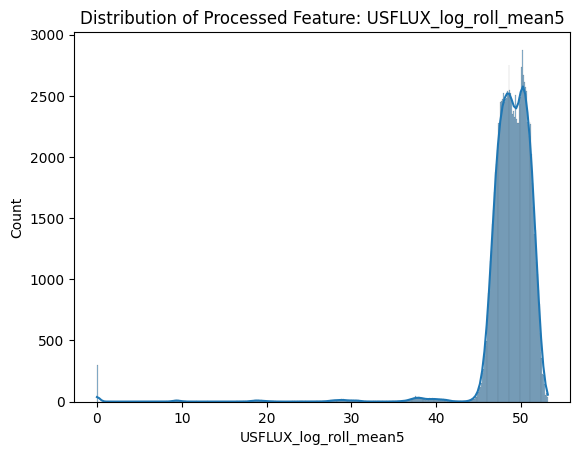



------------- Verifying Distribution for USFLUX_log_roll_std5 -------------

Quantiles for USFLUX_log_roll_std5:
0.00     0.000000
0.25     0.012565
0.50     0.028657
0.75     0.064863
0.90     0.157020
0.95     0.514120
0.99    21.283562
1.00    37.460792
Name: USFLUX_log_roll_std5, dtype: float64


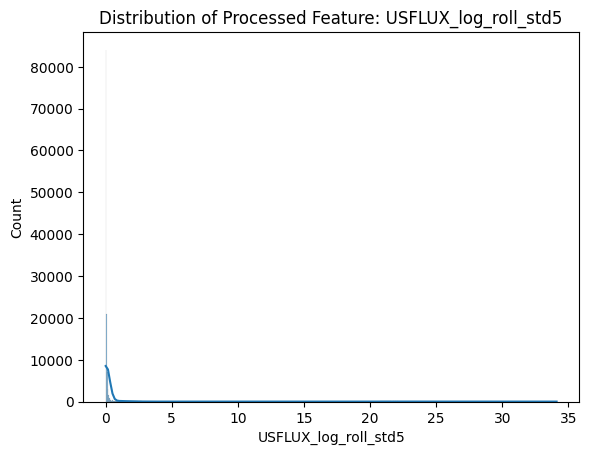



------------- Verifying Distribution for TOTPOT_log_diff1 -------------

Quantiles for TOTPOT_log_diff1:
0.00   -57.311773
0.25    -0.023321
0.50     0.000000
0.75     0.024191
0.90     0.087703
0.95     0.171672
0.99     1.281314
1.00    58.756706
Name: TOTPOT_log_diff1, dtype: float64


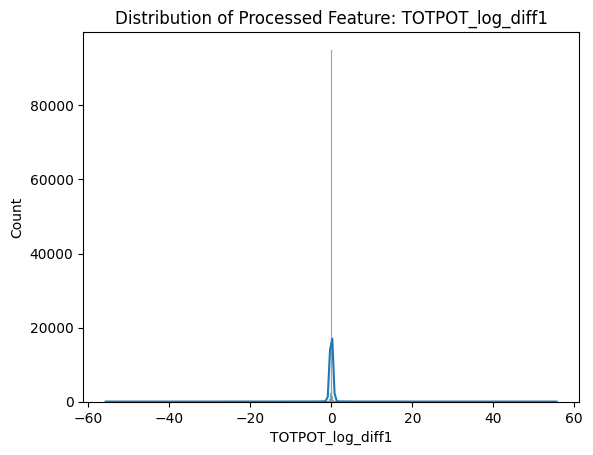



------------- Verifying Distribution for MEANSHR_lag3 -------------

Quantiles for MEANSHR_lag3:
0.00      0.000000
0.25     21.272501
0.50     23.414530
0.75     30.609943
0.90     39.672212
0.95     43.890524
0.99     49.882335
1.00    135.784277
Name: MEANSHR_lag3, dtype: float64


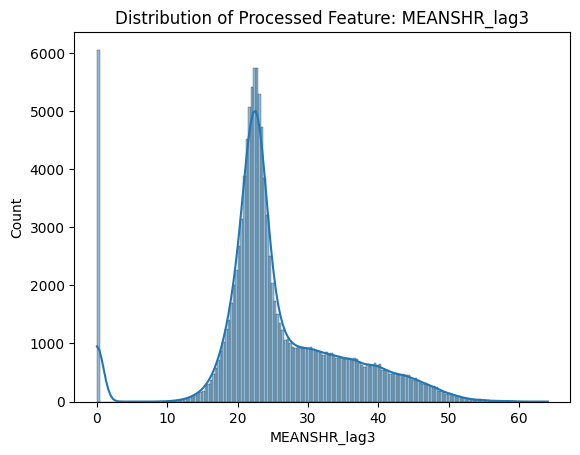

In [8]:
for feature in numeric_ddf.columns:
    print(f"\n\n------------- Verifying Distribution for {feature} -------------\n")
    print(f"Quantiles for {feature}:\n{quantiles[feature]}")
    sns.histplot(data=sample_df, x=feature, kde=True)
    plt.title(f"Distribution of Processed Feature: {feature}")
    save_path = os.path.join(save_dir1, f"{feature}_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# Class Imbalence


--- Verifying Class Distribution ---

Class Distribution:
 label
X       22740
B      697260
M      227100
Q    10345260
C     1234740
Name: count, dtype: int64[pyarrow]


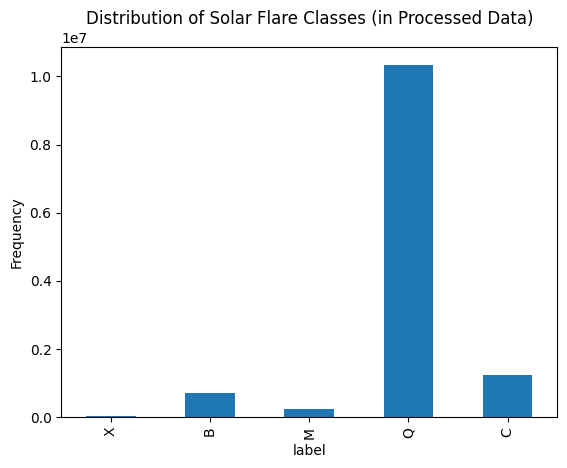

In [9]:
print("\n--- Verifying Class Distribution ---\n")
class_dist = ddf["label"].value_counts().compute()
print("Class Distribution:\n", class_dist)

class_dist.plot(kind = "bar")
plt.title("Distribution of Solar Flare Classes (in Processed Data)")
plt.ylabel("Frequency")
save_path = os.path.join(save_dir1, "class_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Correlational Analysis


--- Verifying Correlation Matrix ---



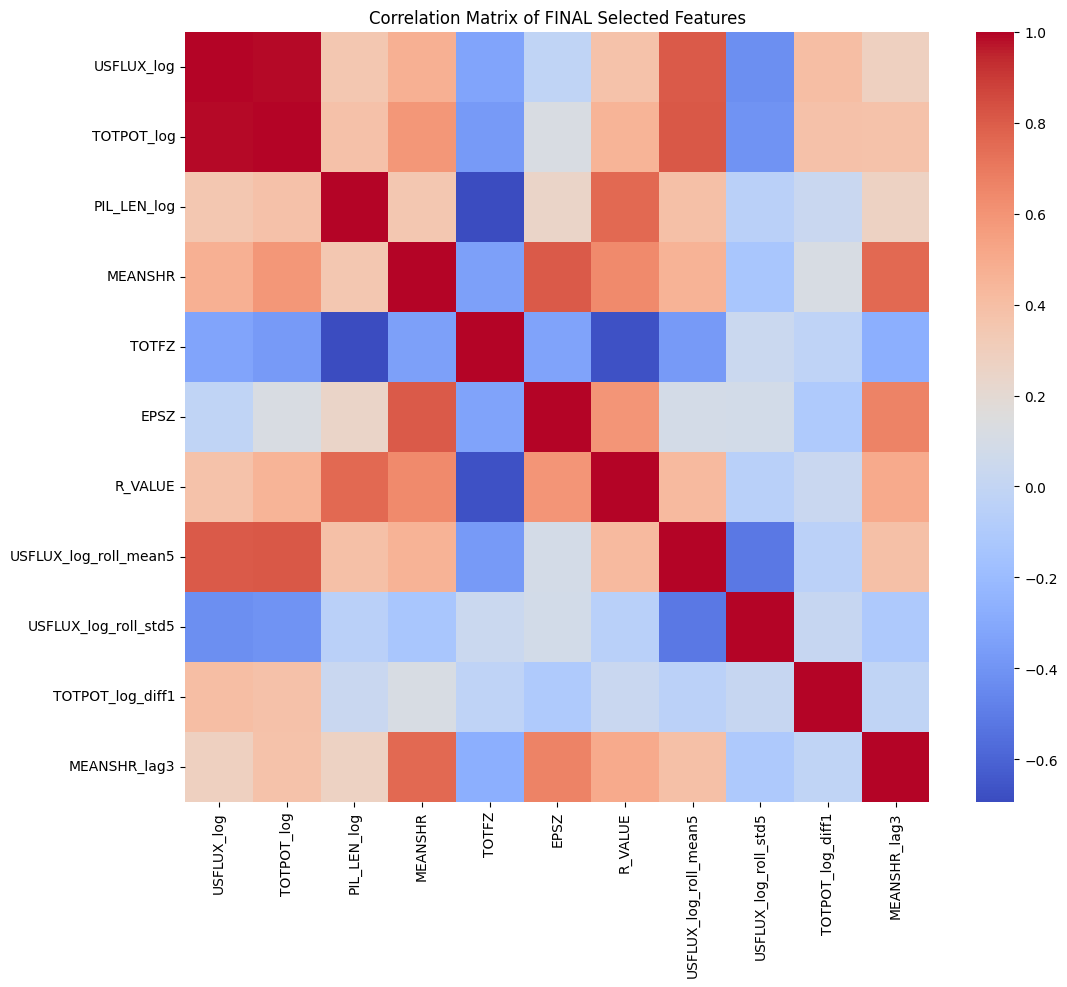

In [10]:
print("\n--- Verifying Correlation Matrix ---\n")
correlation_matrix = numeric_ddf.corr().compute()
plt.figure(figsize = (12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of FINAL Selected Features")
save_path = os.path.join(save_dir1, "correlation_matrix.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()